## Goal
In this experiment I tried applying sinkhorn method to denoise data matrix, and see if it helps find anchor words. (Warning: results differ among different seeds of data simulation)

## Model

Let $Y$ be original count matrix ($dim(Y) = [p, n]$ where $p$ is # of features and $n$ is number of samples). Let $X$ be bi-whitenned version of $Y$. Then we have (as a consequence of bi-whitenning)


\begin{align}
    & X = F L^T + E\\
    & E (\frac{1}{n} E E^T) = I_p
\end{align}

Therefore

\begin{align}
    & E (\frac{1}{n} X X^T) = F A F^T + I_p\\
    & A := E(\frac{1}{n} L^TL)
\end{align}

Then we have a natural estimate (denote $C := F A F^T$)

\begin{align}
    & \hat{C} = \frac{1}{n} X X^T - I_p\\
\end{align}

To denoise $\frac{1}{n} X X^T$ we apply truncated EVD to it (in pratcice just truncated SVD to $\frac{1}{\sqrt{n}} X$)

To estimate $F, A$ with further anchor word assumption, we get $\bar{\hat{C}}$ by row normalizing $\hat{C}$ (to unit l1 norm) then apply the procedure described in https://drive.google.com/file/d/1R9kdE8u8wPpNQgk40YMawHrAuKJtFfTC/view

Note that now the probabilistic interpretation is gone (still have analogous interpretation for $C_{ij}, but not for $\bar{C}$) but we still apply the same algorithm (the following steps need to be changed a bit; todo later) or simply use this for `recoverS`

### Rectification Step
We know $C$ is doubly-nonnegative (nn entries and PSD) but our $ \hat{C}$ may not be so (even without truncated SVD). So we need to project it to a doubly nonnegative matrix. In fact without this step it's hard to improve estimate of $C$ 


## Simulation setup

I simulate a count matrix with 1200 words in dictionary, with 1000 samples, each sample having length 80; there are 3 topics; each topic have 20 top words that are much more highly expressed than the rest words. 


## Results

* Bi-whitenning + truncated SVD (need to way to decide rank) + rectification improves estimate of $C$ and captures more anchor words (but not all)

* But it's still very bad: MLE (even with a mis-specified model) finds the right convex hull / anchor words easily. 

* Also the theory requires $\epsilon p$ to be small where $\epsilon$ is the maximum l1 norm of rows of $\hat{C} - C$. But it's not the case here. 


## Thoughts

* Anchor-word method is fast but no refining step... can we go back and refine it? (we need to improve estimate as long as it's faster than MLE)

* How does error in estimation of $\bar{C}$ affect `recoverS`? This is a MGS (Modified Graham-schimdt) procedure can we understand its sensitivity?

* We denoise estimate of $C$ not directly on $\bar{C}$. Can it be done directly? Different rows of $\bar{C}$ have different quality (l1 distance from truth). Can we incorporate this into MGS? 

* The selected anchor-words are not very different from true anchor words in the row-space of $\hat{\bar{C}}$, but they are so different in the row-space of $\bar{C}$. So the perturbation in $X$ affect estimation of $\bar{C}$ significantly. 


In [1]:
import os
import sys
import pandas as pd
from scipy import sparse

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import seaborn as sns
from matplotlib.colors import LogNorm



script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 

np.random.seed(12345)

In [2]:
n = 1000
p = 1200 ## make this larger to increase difficulty
n_top = 20 ## number of top words in each topic
k = 3
doc_len = 80

X, Atrue, Ftrue, p0, Ltrue = smallsim_independent(n = n, p = p, 
                                           k = k, doc_len = doc_len, 
                                           n_top = n_top, returnL=True)
w_idx = np.where(X.sum(axis = 0) > 0)[0]
X = X[:,w_idx]

In [3]:
Xn, r, c = sinkhorn(X, niter = 100)

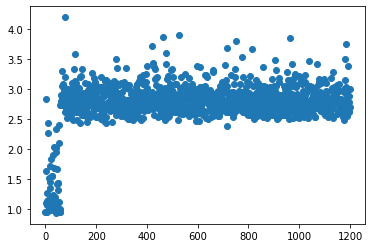

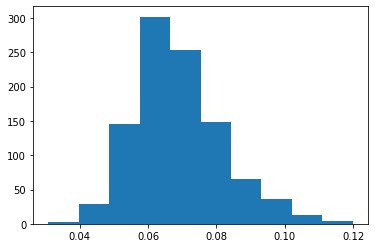

In [4]:
plt.scatter(w_idx, np.log10(c))
plt.show()

plt.hist(r) ## each document has length 80
plt.show()

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0102 seconds

recovered S from true Ctilde


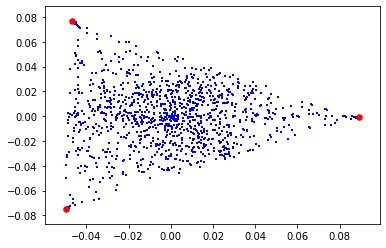

In [5]:
Ftilde = np.diag(c) @ Ftrue[w_idx,:]
Ltilde = np.diag(r) @ Ltrue

C = Ftrue[w_idx,:] @ Atrue @ Ftrue[w_idx,:].T
Atilde = (Ltilde.T @ Ltilde) / n
Ctilde = Ftilde @ Atilde @ Ftilde.T

Ctilde_bar = Ctilde/Ctilde.sum(axis=1)[:,None]
Ctilde_bar_proj = Cbar_proj(Ctilde_bar)

Cbar = C/C.sum(axis=1)[:,None]
Cbar_pj = Cbar_proj(Cbar)


which_dim = [0, 1]

S,_,_ = findS(Ctilde_bar,k)

print("recovered S from true Ctilde")
vis_extremal_pca(Cbar_pj, S, which_dim)

## Without bi-whitenning

* Below we can see the recovered anchor words are very bad; it's because estimated $\hat{C}$ has some extremal points of low quality...

* So next let's see if we can do better 

[file.bows2C] Start constructing dense C...
- Counting the co-occurrence for each document...
+ Finish constructing C and D!
  - The sum of all entries = 1.000000
  - Elapsed Time = 0.1827 seconds
+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.5872

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0093 seconds

recovered S from C-estimated, visualized on true Cbar


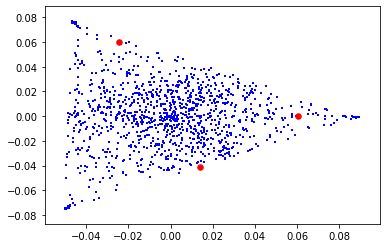

true S visualized on Cbar estimated


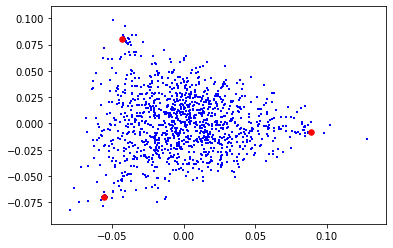

In [6]:
Chat, _, _ = X2C(sparse.coo_matrix(X))
Chat, _, _ = rectifyC(Chat, k)
Chat_bar = Chat/Chat.sum(axis=1)[:,None]
Sfit,_,_ = findS(Chat_bar,k)

print("recovered S from C-estimated, visualized on true Cbar")
vis_extremal_pca(Cbar_pj, Sfit, which_dim)

print("true S visualized on Cbar estimated")
Chat_bar_pj = Cbar_proj(Chat_bar)
vis_extremal_pca(Chat_bar_pj, S, which_dim)




## Without SVD (full SVD and reconstrcuted...)

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.6376



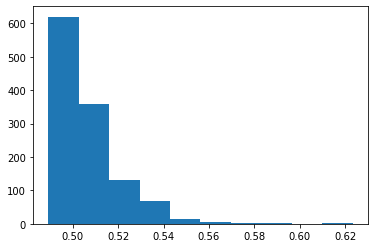

max l1 error from anchor row 0.5399979555526673
total l1 error 607.1358630231329
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0125 seconds

recovered S from Ctilde_svd1000 + rectify


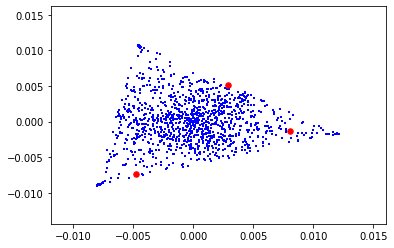

true S visualized on Ctilde_svd1000 + rectify


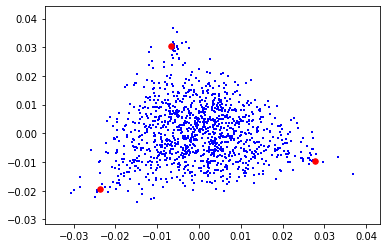

In [7]:
Ctilde_svd = X2C_svd(Xn, r = 1000)
Ctilde_svd_bar = Ctilde_svd/Ctilde_svd.sum(axis = 1)[:, None]

# plt.hist(np.abs(Ctilde_svd_bar - Ctilde_bar).sum(axis = 1))
# plt.show()

# plt.hist(np.abs(Ctilde_svd_bar - Ctilde_bar).sum(axis = 1)[:60])
# plt.show()


# Shat,_,_ = findS(Ctilde_svd_bar,k)
# print("recovered S from Ctilde_svd200")
# vis_extremal_pca(Cbar_pj, Shat, which_dim)

Ctilde_svd_rect, _, _ = rectifyC(Ctilde_svd, k)
Ctilde_svd_rect_bar = Ctilde_svd_rect / Ctilde_svd_rect.sum(axis = 1)[:, None]
plt.hist(np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum(axis = 1))
plt.show()

max_err_anchor = np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum(axis = 1)[:60].max()
tot_err = np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum()
print(f"max l1 error from anchor row {max_err_anchor}")
print(f"total l1 error {tot_err}")

Shat,_,_ = findS(Ctilde_svd_rect_bar,k)
print("recovered S from Ctilde_svd1000 + rectify")
vis_extremal_pca(Ctilde_bar_proj, Shat, which_dim)

print("true S visualized on Ctilde_svd1000 + rectify")
Ctilde_svd_rect_bar_pj = Cbar_proj(Ctilde_svd_rect_bar)
vis_extremal_pca(Ctilde_svd_rect_bar_pj, S, which_dim)



## SVD with rank 200

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.5790



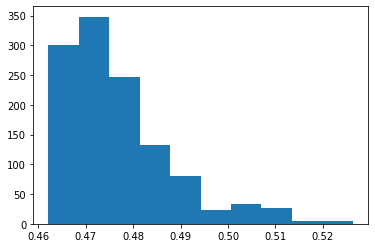

max l1 error from anchor row 0.5124043484498783
total l1 error 572.0243285505571
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0097 seconds

recovered S from Ctilde_svd200 + rectify


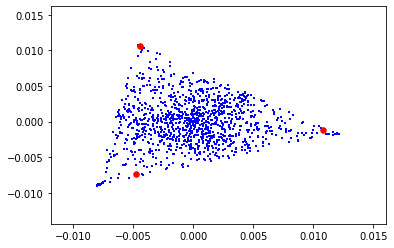

true S visualized on Ctilde_svd200 + rectify


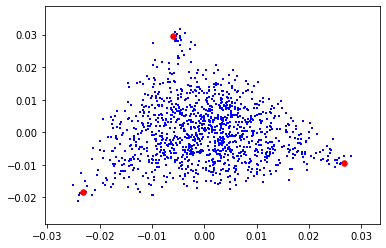

In [8]:
Ctilde_svd = X2C_svd(Xn, r = 200)
Ctilde_svd_bar = Ctilde_svd/Ctilde_svd.sum(axis = 1)[:, None]

Ctilde_svd_rect, _, _ = rectifyC(Ctilde_svd, k)
Ctilde_svd_rect_bar = Ctilde_svd_rect / Ctilde_svd_rect.sum(axis = 1)[:, None]
plt.hist(np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum(axis = 1))
plt.show()
max_err_anchor = np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum(axis = 1)[:60].max()
tot_err = np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum()
print(f"max l1 error from anchor row {max_err_anchor}")
print(f"total l1 error {tot_err}")


Shat,_,_ = findS(Ctilde_svd_rect_bar,k)
print("recovered S from Ctilde_svd200 + rectify")
vis_extremal_pca(Ctilde_bar_proj, Shat, which_dim)

print("true S visualized on Ctilde_svd200 + rectify")
Ctilde_svd_rect_bar_pj = Cbar_proj(Ctilde_svd_rect_bar)
vis_extremal_pca(Ctilde_svd_rect_bar_pj, S, which_dim)


## SVD with rank 100

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.6437



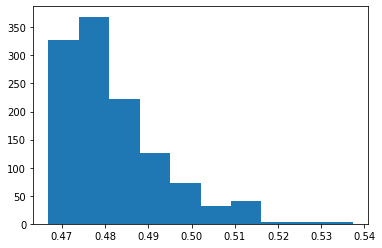

max l1 error from anchor row 0.5172697919004221
total l1 error 578.1993475997169
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0161 seconds

recovered S from Ctilde_svd100 + rectify


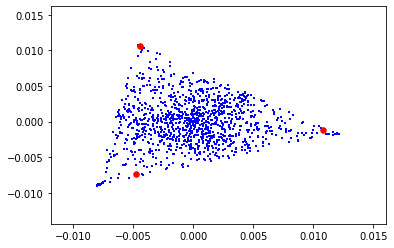

true S visualized on Ctilde_svd100 + rectify


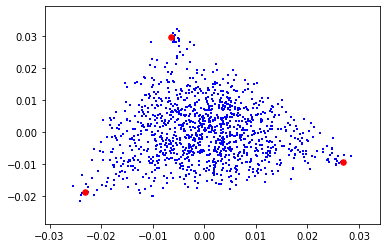

In [9]:
Ctilde_svd = X2C_svd(Xn, r = 100)
Ctilde_svd_bar = Ctilde_svd/Ctilde_svd.sum(axis = 1)[:, None]

Ctilde_svd_rect, _, _ = rectifyC(Ctilde_svd, k)
Ctilde_svd_rect_bar = Ctilde_svd_rect / Ctilde_svd_rect.sum(axis = 1)[:, None]

plt.hist(np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum(axis = 1))
plt.show()
max_err_anchor = np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum(axis = 1)[:60].max()
tot_err = np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum()
print(f"max l1 error from anchor row {max_err_anchor}")
print(f"total l1 error {tot_err}")




Shat,_,_ = findS(Ctilde_svd_rect_bar,k)
print("recovered S from Ctilde_svd100 + rectify")
vis_extremal_pca(Ctilde_bar_proj, Shat, which_dim)

print("true S visualized on Ctilde_svd100 + rectify")
Ctilde_svd_rect_bar_pj = Cbar_proj(Ctilde_svd_rect_bar)
vis_extremal_pca(Ctilde_svd_rect_bar_pj, S, which_dim)


## SVD with rank 50

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.6906



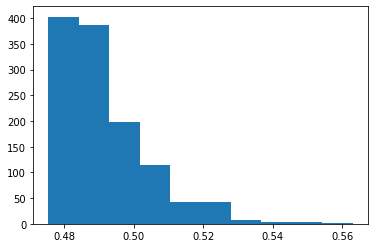

max l1 error from anchor row 0.5265827716473588
total l1 error 589.5330637979635
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0187 seconds

recovered S from Ctilde_svd50 + rectify


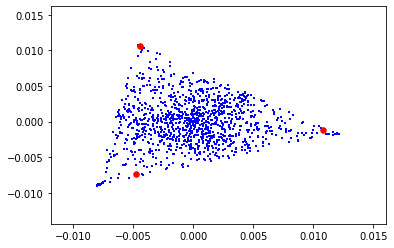

true S visualized on Ctilde_svd50 + rectify


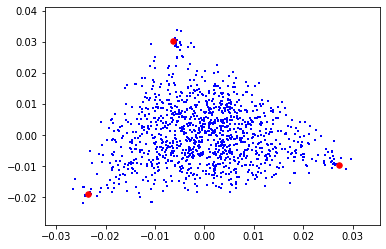

In [10]:
Ctilde_svd = X2C_svd(Xn, r = 50)
Ctilde_svd_bar = Ctilde_svd/Ctilde_svd.sum(axis = 1)[:, None]

Ctilde_svd_rect, _, _ = rectifyC(Ctilde_svd, k)
Ctilde_svd_rect_bar = Ctilde_svd_rect / Ctilde_svd_rect.sum(axis = 1)[:, None]
plt.hist(np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum(axis = 1))
plt.show()
max_err_anchor = np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum(axis = 1)[:60].max()
tot_err = np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum()
print(f"max l1 error from anchor row {max_err_anchor}")
print(f"total l1 error {tot_err}")




Shat,_,_ = findS(Ctilde_svd_rect_bar,k)
print("recovered S from Ctilde_svd50 + rectify")
vis_extremal_pca(Ctilde_bar_proj, Shat, which_dim)

print("true S visualized on Ctilde_svd50 + rectify")
Ctilde_svd_rect_bar_pj = Cbar_proj(Ctilde_svd_rect_bar)
vis_extremal_pca(Ctilde_svd_rect_bar_pj, S, which_dim)

## SVD with rank 3

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.5490



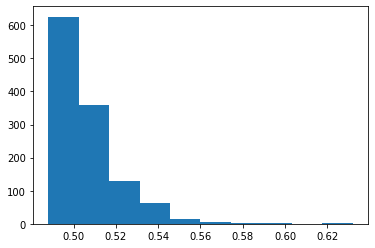

max l1 error from anchor row 0.5403747780265028
total l1 error 606.8873420662425
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0099 seconds

recovered S from Ctilde_svd3 + rectify


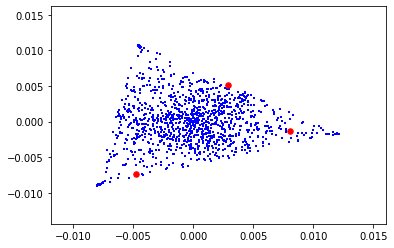

true S visualized on Ctilde_svd3 + rectify


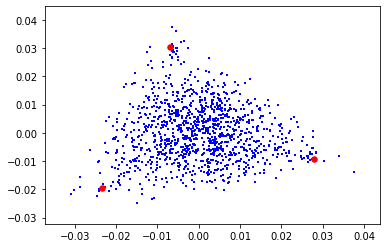

In [11]:
Ctilde_svd = X2C_svd(Xn, r = 3)
Ctilde_svd_bar = Ctilde_svd/Ctilde_svd.sum(axis = 1)[:, None]

Ctilde_svd_rect, _, _ = rectifyC(Ctilde_svd, k)
Ctilde_svd_rect_bar = Ctilde_svd_rect / Ctilde_svd_rect.sum(axis = 1)[:, None]
plt.hist(np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum(axis = 1))
plt.show()
max_err_anchor = np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum(axis = 1)[:60].max()
tot_err = np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum()
print(f"max l1 error from anchor row {max_err_anchor}")
print(f"total l1 error {tot_err}")



Shat,_,_ = findS(Ctilde_svd_rect_bar,k)
print("recovered S from Ctilde_svd3 + rectify")
vis_extremal_pca(Ctilde_bar_proj, Shat, which_dim)

print("true S visualized on Ctilde_svd3 + rectify")
Ctilde_svd_rect_bar_pj = Cbar_proj(Ctilde_svd_rect_bar)
vis_extremal_pca(Ctilde_svd_rect_bar_pj, S, which_dim)

### Can we find anchor words by using bigger $K$?

In [12]:
Ctilde_svd = X2C_svd(Xn, r = 200)
Ctilde_svd_bar = Ctilde_svd/Ctilde_svd.sum(axis = 1)[:, None]
Ctilde_svd_rect, _, _ = rectifyC(Ctilde_svd, k)
Ctilde_svd_rect_bar = Ctilde_svd_rect / Ctilde_svd_rect.sum(axis = 1)[:, None]

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.7140



[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 4 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0221 seconds

recovered S with 4 topics


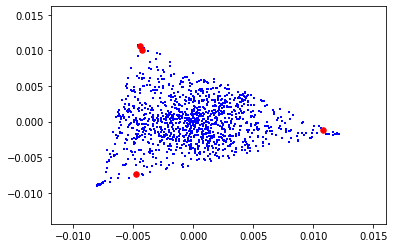

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 5 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0229 seconds

recovered S with 5 topics


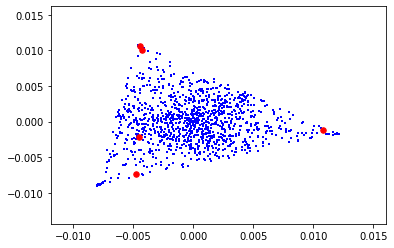

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0294 seconds

recovered S with 6 topics


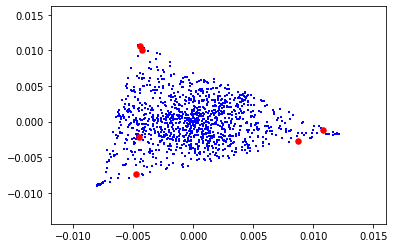

In [13]:
Shat,_,_ = findS(Ctilde_svd_rect_bar,k+1)
print(f"recovered S with {k+1} topics")
vis_extremal_pca(Ctilde_bar_proj, Shat, which_dim)

Shat,_,_ = findS(Ctilde_svd_rect_bar,k+2)
print(f"recovered S with {k+2} topics")
vis_extremal_pca(Ctilde_bar_proj, Shat, which_dim)

Shat,_,_ = findS(Ctilde_svd_rect_bar,k+3)
print(f"recovered S with {k+3} topics")
vis_extremal_pca(Ctilde_bar_proj, Shat, which_dim)


## Find the good $r$

For now let's use oracle $C$ just to see what a best $r$ can do

In [14]:
rs = [100, 120, 140, 160, 180, 200, 220, 240, 260]
tot_errs = []

for r in rs:

    Ctilde_svd = X2C_svd(Xn, r = r)
    Ctilde_svd_rect, _, _ = rectifyC(Ctilde_svd, k)
    Ctilde_svd_rect_bar = Ctilde_svd_rect / Ctilde_svd_rect.sum(axis = 1)[:, None]

    tot_errs.append(
        np.abs(Ctilde_svd_rect_bar - Ctilde_bar).sum())
    

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.5471

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.5418

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.8206

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.5594

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.6644

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.5442

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.5510

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.5604

+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 0.5671



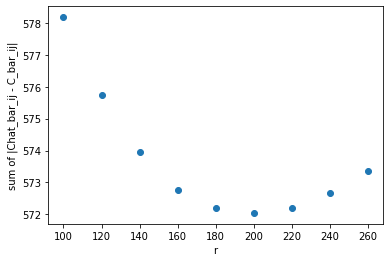

In [39]:
plt.scatter(rs, tot_errs)
plt.xlabel("r")
plt.ylabel("sum of |Chat_bar_ij - C_bar_ij|")
plt.show()

so $r = 200$ is probably close to what the best we can do with this approach... still not very satisfying

## MLE has no problem finding the right anchor words / convex hull

In [16]:
model = NMF(n_components=k, beta_loss = 'kullback-leibler',
            solver = 'mu', 
            init='random', random_state=0)
W = model.fit_transform(X.T)
H = model.components_

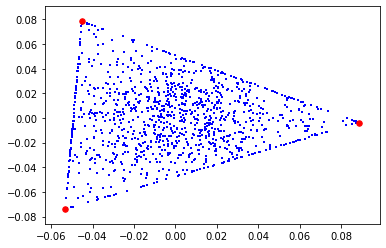

In [17]:
Anmf = (H @ H.T) / n 
Cnmf = W @ Anmf @ W.T
Cnmf_bar = Cnmf/Cnmf.sum(axis=1)[:,None]
Cnmf_bar_pj = Cbar_proj(Cnmf)


vis_extremal_pca(Cnmf_bar_pj, S, which_dim)
## vis_extremal_pca(Cnmf_bar_pj, S, which_dim = [1,2])




Even with Frobenius norm we can get the right structure!!!

(This shows how easy this problem is)

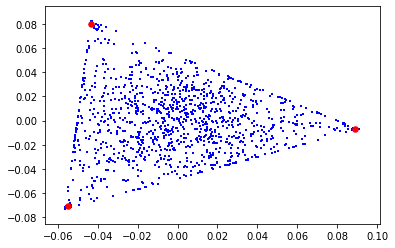

In [18]:
model2 = NMF(n_components=k, 
            solver = 'mu', 
            init='random', random_state=0)
W = model2.fit_transform(X.T)
H = model2.components_

Anmf = (H @ H.T) / n 
Cnmf = W @ Anmf @ W.T
Cnmf_bar = Cnmf/Cnmf.sum(axis=1)[:,None]
Cnmf_bar_pj = Cbar_proj(Cnmf)


vis_extremal_pca(Cnmf_bar_pj, S, which_dim)

